In [1]:
suppressPackageStartupMessages({
    library(dplyr)
    library(Seurat)
    library(patchwork)
    })

## Generate a Seurat Object

In [2]:
# Load the Mouse Amygdala Opioid Dependence (MAOD) dataset (sample N1: amygdala of naive mouse rep1)
# barcodes.tsv (list of all cell identifiers), features.tsv (all annotated genes), matrix.mt (expression matrix of all genes)
# The Read10X returns a unique molecular identified (UMI) count matrix
# The values in this matrix represent the number of molecules for each feature (row) that are detected in each cell (col)
N1.data <- Read10X(data.dir = "data/GSE207128_RAW/N1")

# Let's inspect a few genes in the count matrix
# The . values represent 0s (no molecules detected)
head(N1.data[, 1:30])

  [[ suppressing 30 column names 'AAACCCAAGTCACGCC-1', 'AAACCCAAGTGGTTCT-1', 'AAACCCAAGTTCTCTT-1' ... ]]



6 x 30 sparse Matrix of class "dgCMatrix"
                                                                   
Xkr4    . . . . . 4 . . . . . . . . . . . . . . . . . . . . . . . .
Gm1992  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Gm19938 . . . . . 2 . . . 3 . . . . . 2 . . . . . 1 . . . . 2 . . .
Gm37381 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Rp1     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Sox17   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

In [3]:
# Initialize the Seurat object with the raw data
# The object will contain both the data and further analysis that we will carry out (i.e. PCA, or clustering results)
N1 <- CreateSeuratObject(counts = N1.data, project = "N1", min.cells = 3, min.features = 200)
N1

# The number of unique genes and total molecules are calculated and stored in the object meta data
# nCount_RNA is the total number of molecules detected within a cell
# nFeature_RNA is the number of genes detected in each cell
head(N1@meta.data)

An object of class Seurat 
22167 features across 11471 samples within 1 assay 
Active assay: RNA (22167 features, 0 variable features)
 1 layer present: counts

,orig.ident,nCount_RNA,nFeature_RNA
,<fct>,<dbl>,<int>
AAACCCAAGTCACGCC-1,N1,11802,3415
AAACCCAAGTGGTTCT-1,N1,2486,917
AAACCCAAGTTCTCTT-1,N1,2019,996
AAACCCAAGTTGAAAC-1,N1,1028,638
AAACCCACATGACTTG-1,N1,1952,986
AAACCCAGTACAGTCT-1,N1,45448,6041


## Pre-processing

Select and filter cells with the following QC metrics: 
- cells with very few unique genes
- cells with low total number of molecules detected
- cells with high percentage of reads that map to the mitocondrial genome (often signifying low quality or dying cells)

In [4]:
# Calculate the percentage of counts that map to the mitochondrial genome
N1[["percent.mt"]] <- PercentageFeatureSet(N1, pattern = "^mt-")

# Examine the data
head(N1@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACCCAAGTCACGCC-1,N1,11802,3415,4.905948
AAACCCAAGTGGTTCT-1,N1,2486,917,28.399035
AAACCCAAGTTCTCTT-1,N1,2019,996,14.314017
AAACCCAAGTTGAAAC-1,N1,1028,638,9.046693
AAACCCACATGACTTG-1,N1,1952,986,7.069672
AAACCCAGTACAGTCT-1,N1,45448,6041,5.307164


Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."


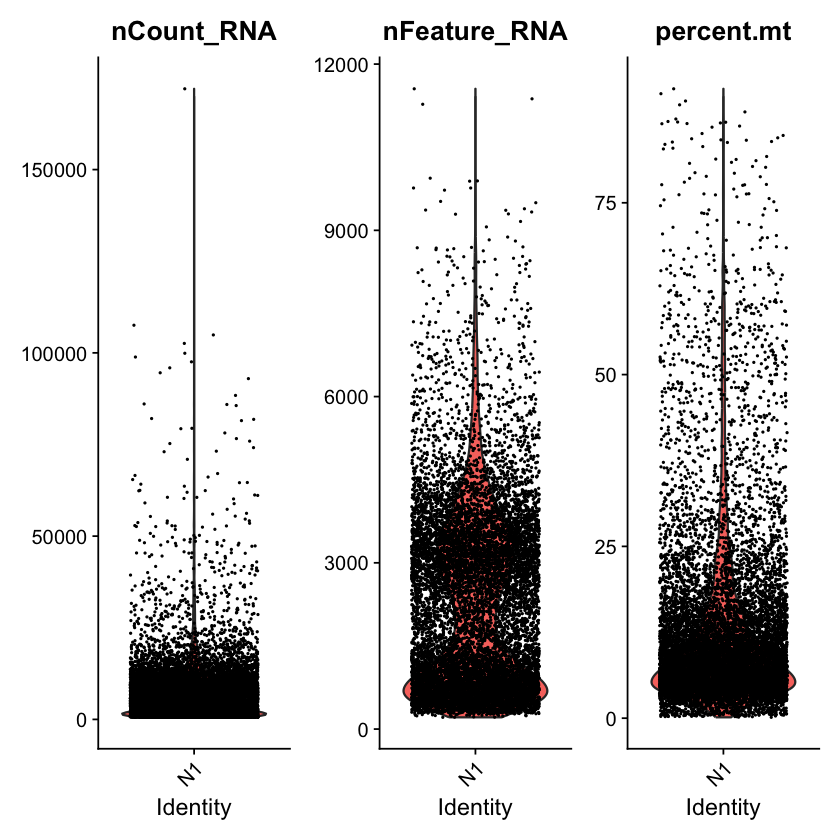

In [5]:
# Visualize QC metrics
VlnPlot(N1, features = c("nCount_RNA","nFeature_RNA", "percent.mt"), ncol = 3)

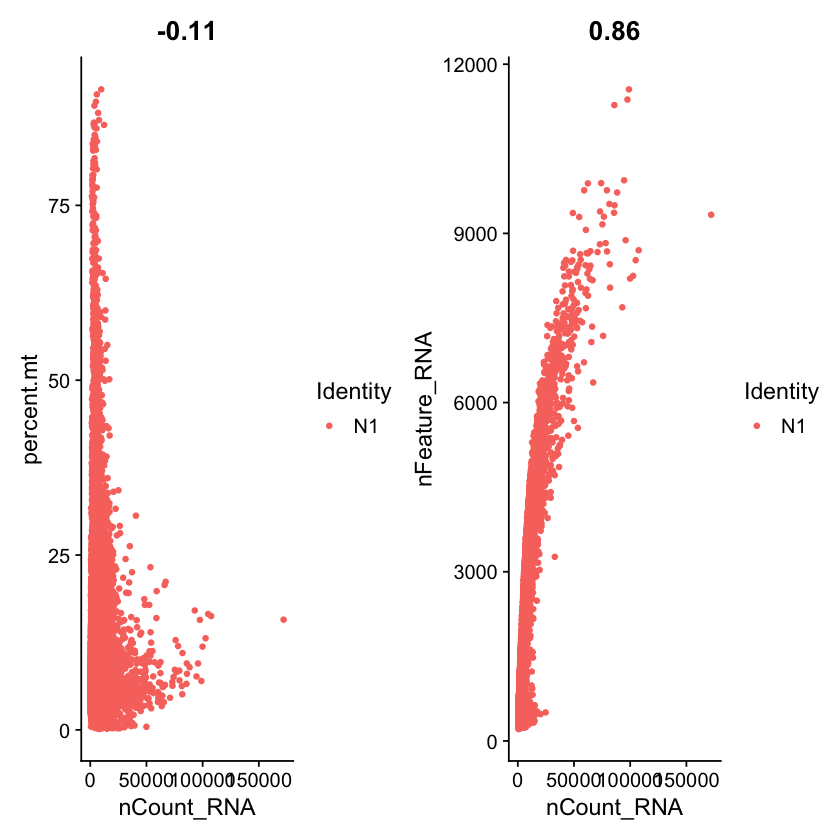

In [6]:
# Visualize feature-feature relationships
plot1 <- FeatureScatter(N1, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(N1, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [7]:
# We filter cells that have unique feature (gene) counts over 2,500 or less than 200, and cells that have >5% mitochondrial counts
N1 <- subset(N1, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."


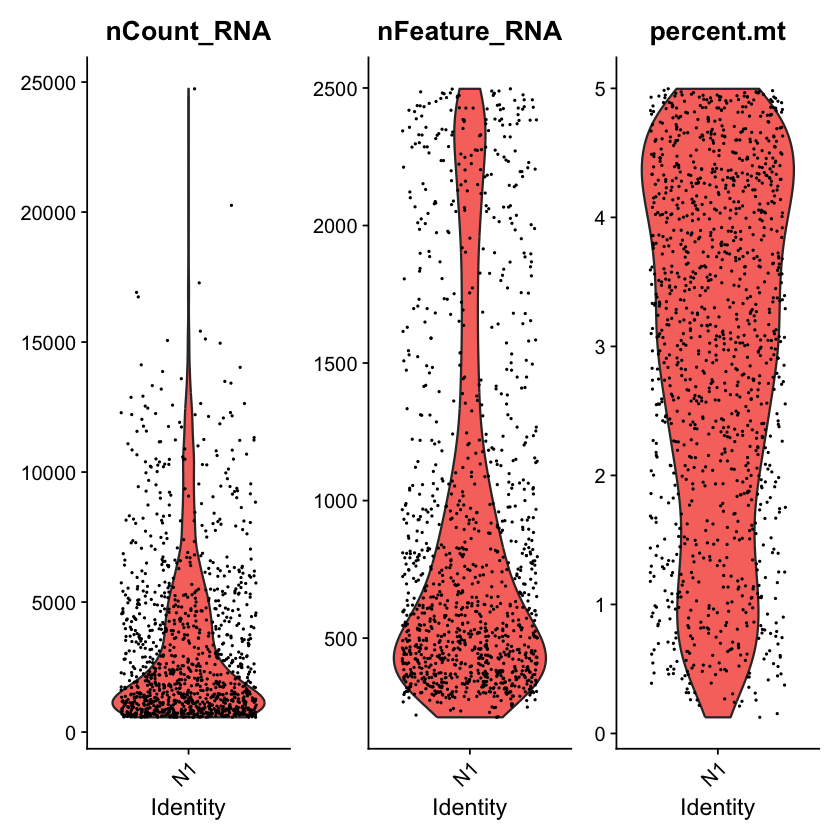

In [8]:
# Visualize QC metrics after filtering step 
VlnPlot(N1, features = c("nCount_RNA","nFeature_RNA", "percent.mt"), ncol = 3)

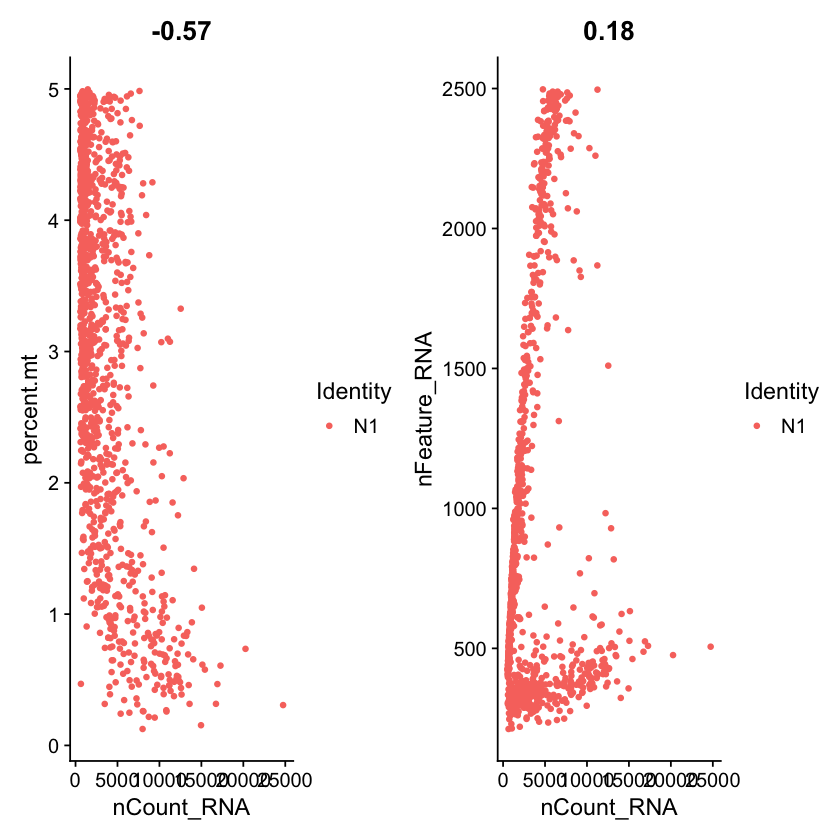

In [9]:
# Visualize feature-feature relationships after filtering step
plot1 <- FeatureScatter(N1, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(N1, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

## Normalization

In [10]:
# A global-scaling normalization method is used here, which normalizes the feature expression measurements (nFeature_RNA) 
# for each cell by the total expression (nCounts_RNA),
# multiplies this by a scale factor of 10000 and log-transforms the result.
# This normalization method assumes that each cell contains the same number of RNA molecules.
N1 <- NormalizeData(N1, normalization.method = "LogNormalize", scale.factor = 10000)

Normalizing layer: counts



In [11]:
# Normalized values are stored in the Seurat Object
head(N1[["RNA"]]$counts[,1:30])

  [[ suppressing 30 column names 'AAACCCATCGAACTCA-1', 'AAAGAACAGAAGCGAA-1', 'AAAGGGCAGCACCTGC-1' ... ]]



6 x 30 sparse Matrix of class "dgCMatrix"
                                                                   
Xkr4    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Gm19938 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Gm37381 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Rp1     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Sox17   . . . . . . . . . . . . . . . . . . . . . 1 . . . . . . . .
Gm37587 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

## Feature selection

Finding variable features for layer counts

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
"log-10 transformation introduced infinite values."
Warning message in scale_x_log10():
"log-10 transformation introduced infinite values."


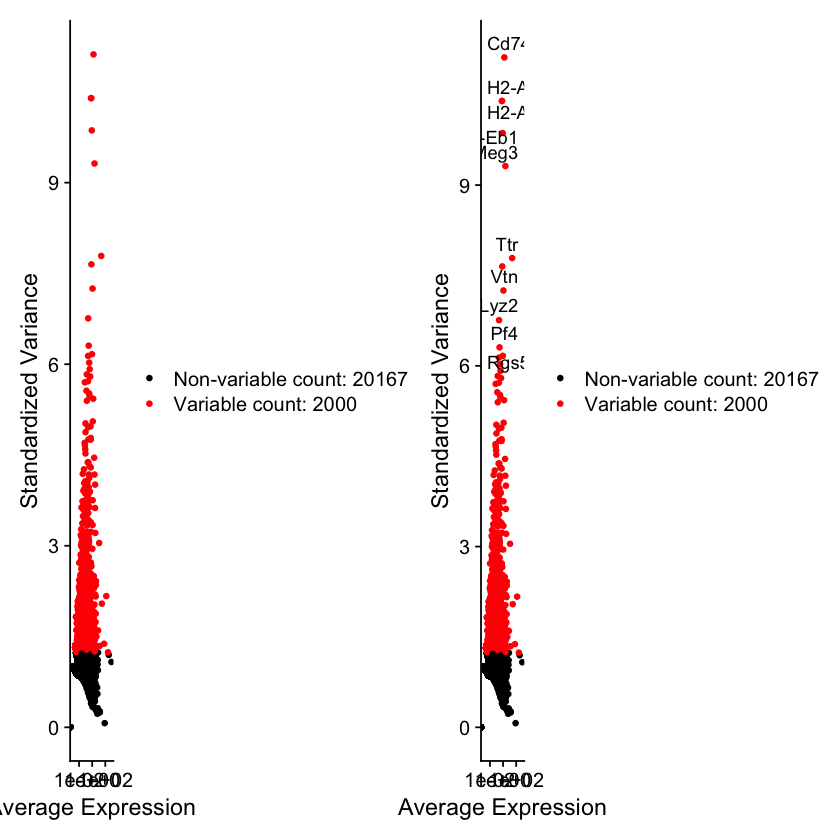

In [12]:
# Select a subset of features that exhibit high cell-to-cell variation (highly expressed in some cells and lowly in others)
N1 <- FindVariableFeatures(N1, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(N1), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(N1)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1 + plot2

## Scaling the data

In [13]:
# Scaling the data as a pre-processing step prior to dimensional reduction techniques
all.genes <- rownames(N1)
N1 <- ScaleData(N1, features = all.genes)

Centering and scaling data matrix



## PCA

In [14]:
# Run PCA with the 2000 variable features determined in the previous step
N1 <- RunPCA(N1, features = VariableFeatures(object = N1))

PC_ 1 
Positive:  Csf1r, C1qc, Fcer1g, Cx3cr1, C1qa, Ly86, Unc93b1, Ctss, Lgmn, Tyrobp 
	   C1qb, Vsir, Fcrls, Cyth4, Selplg, Apbb1ip, Siglech, Mafb, Fcgr1, Tmem119 
	   Hexb, P2ry12, Ifngr1, Gpr34, Cyba, Hpgds, Spi1, Irf8, Olfml3, Pld4 
Negative:  Hba-a2, Alas2, Bpgm, Ube2l6, Snca, Clu, Slc1a2, Car2, Aldoc, Rec114 
	   Bcan, Cspg5, Gja1, Mkrn1, Sparcl1, Chchd10, Enpp2, Ndrg2, Cpe, Slc4a4 
	   Dclk1, Gpr37l1, Dbi, Mfge8, Plpp3, Hbq1a, Cryab, Cldn10, Scg3, Gm3764 
PC_ 2 
Positive:  Ly6c1, Cxcl12, Flt1, Adgrl4, Ly6a, Hspb1, Cldn5, Ptprb, Igfbp7, Slco1a4 
	   Itm2a, Abcb1a, Slc9a3r2, Vwa1, Pltp, Slc2a1, Nes, Sema3c, Jcad, Clic5 
	   Abcg2, Cdh5, Ramp2, Ltbp4, Srarp, Ifitm3, Ctla2a, Col4a2, Pglyrp1, Spock2 
Negative:  Hba-a2, Alas2, C1qa, C1qb, Tmem119, C1qc, Fcrls, Ctss, Siglech, Csf1r 
	   Hpgds, Cx3cr1, Ly86, Lgmn, P2ry12, Selplg, Olfml3, Ccr5, Fcgr1, P2ry13 
	   Gpr34, Tgfbr1, Itgam, Hk2, Cd68, Cyth4, Ube2l6, Pou2f2, Slc2a5, Bin2 
PC_ 3 
Positive:  2900040C04Rik, Calml4, Krt18, Chchd10

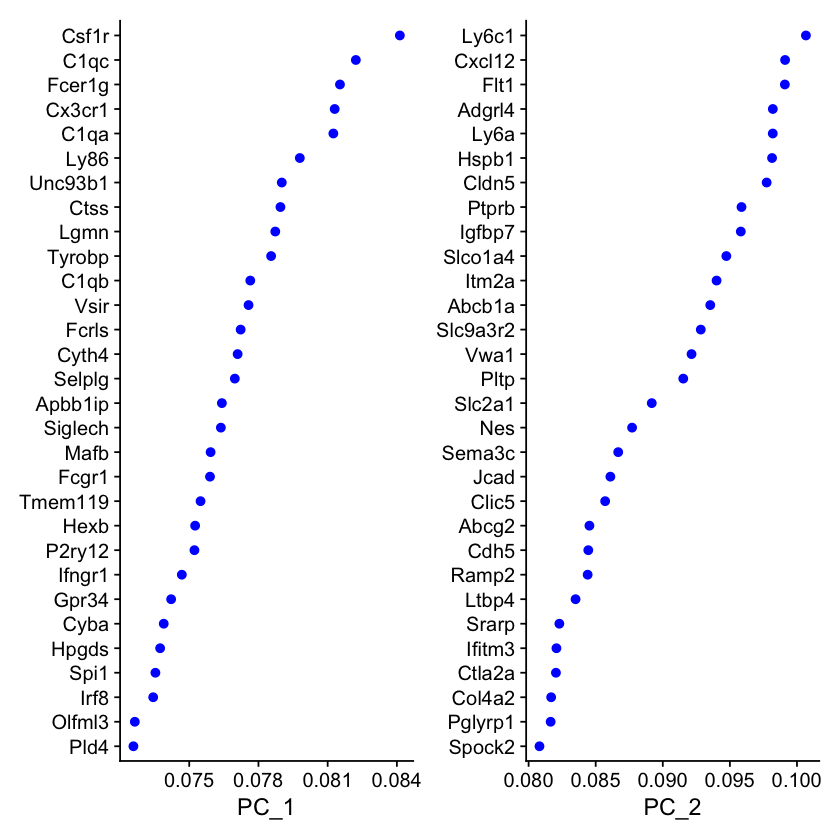

In [15]:
# Visualize loading plot of top genes associated with reduction components 
VizDimLoadings(N1, dims = 1:2, reduction = "pca")

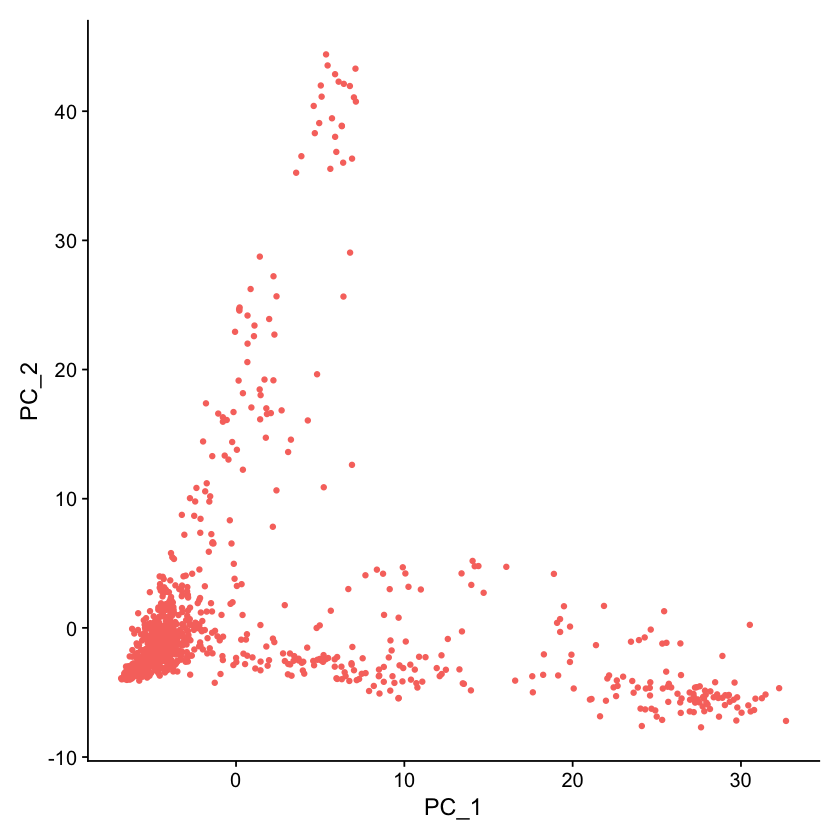

In [16]:
# Visualize the output of the PCA, where each point is a cell
DimPlot(N1, reduction = "pca") + NoLegend()

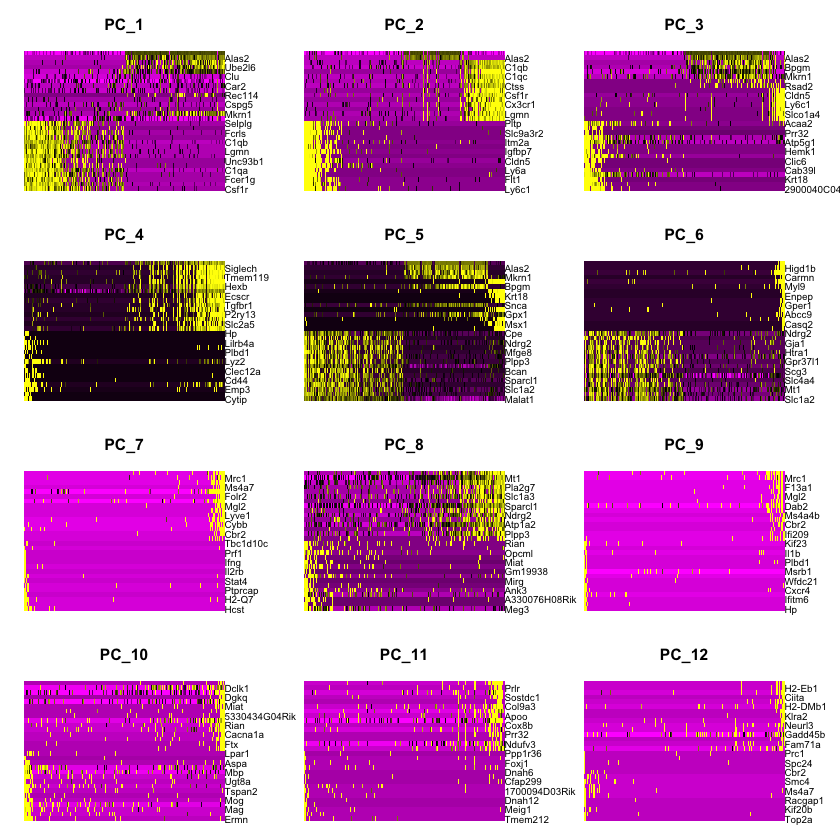

In [17]:
# Heatmap of each PC
# Allows for easy exploration of the primary sources of heterogeneity in a dataset
DimHeatmap(N1, dims = 1:12, cells = 500, balanced = TRUE)

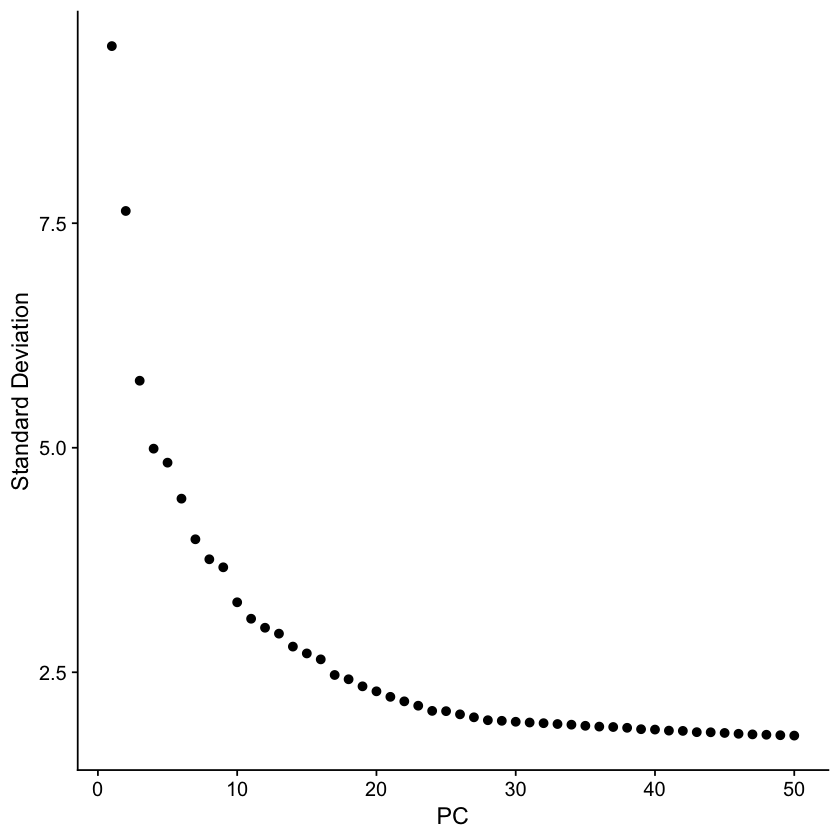

In [18]:
# The elbow plot shows that the majority of true signal is captures in the first 25 PCs
ElbowPlot(N1, ndims = 50)

## Cluster the cells

In [20]:
N1 <- Seurat::FindNeighbors(N1, dims = 1:25)
N1 <- FindClusters(N1, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1162
Number of edges: 39219

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8729
Number of communities: 9
Elapsed time: 0 seconds


## Differential Expression